# Summarize performance on each memory task

In [1]:
import pandas as pd
import numpy as np
import datawrangler as dw
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
import hypertools as hyp
from sklearn.linear_model import LinearRegression

import nltk
import quail
import warnings
import os
import pickle

from loader import load, get_formatted_data, get_raw_feature, get_list_items, get_video_and_recall_trajectories, DATA_DIR, sliding_windows, precision, spatial_estimation_error
from free_recall import create_fr_plots, split_by_feature, distplot, get_bounds
from naturalistic_recall import plot_trajectories, plotter

Load the data:

In [2]:
data = get_formatted_data()
behavioral, _, _ = load(recent=7, baseline=30)

Define the color scheme:

In [3]:
tasks = ['Free recall', 'Naturalistic recall', 'Foreign language flashcards', 'Spatial learning']
conditions = ['Immediate', 'Delayed']

bounds = [0, 25, 50, 75, 100]
task_colors = {t: c for t, c in zip(tasks, ['#3FA9F5', '#7AC943', '#FF931E', '#FF1D25'])}
condition_colors = ['#CCCCCC', '#1A1A1A']

task_cmaps = {t: sns.color_palette(f'light:{c}', n_colors=len(bounds)) for t, c in task_colors.items()}

In [4]:
task_cmaps['Free recall']

[(0.9391249535816234, 0.9440090702273087, 0.9510479803029003),
 (0.765429924862637, 0.8734173281879442, 0.9534916090834719),
 (0.5917348961436505, 0.8028255861485797, 0.9559352378640434),
 (0.41803986742466404, 0.7322338441092151, 0.958378866644615),
 (0.24705882352941178, 0.6627450980392157, 0.9607843137254902)]

In [5]:
task_cmaps['Naturalistic recall']

[(0.9252147360653771, 0.9515681132369823, 0.915523834353121),
 (0.8130808722808796, 0.9105747782423256, 0.7516891711213958),
 (0.700947008496382, 0.869581443247669, 0.5878545078896705),
 (0.5888131447118844, 0.8285881082530122, 0.4240198446579453),
 (0.47843137254901963, 0.788235294117647, 0.2627450980392157)]

In [6]:
task_cmaps['Foreign language flashcards']

[(0.9523350913995353, 0.9414835876622112, 0.9370303819380711),
 (0.9642980488522009, 0.8498724819236908, 0.73138123417599),
 (0.9762610063048666, 0.7582613761851704, 0.525732086413909),
 (0.9882239637575323, 0.66665027044665, 0.320082938651828),
 (1.0, 0.5764705882352941, 0.11764705882352941)]

In [7]:
task_cmaps['Spatial learning']

[(0.9522623337809554, 0.9411011837400192, 0.9410484825414952),
 (0.9642435519692646, 0.7334461077133047, 0.7412805281381549),
 (0.9762247701575738, 0.5257910316865901, 0.5415125737348147),
 (0.9882059883458831, 0.3181359556598756, 0.3417446193314744),
 (1.0, 0.11372549019607843, 0.1450980392156863)]

# Free recall

Detailed plots:
  - probability of first recall
  - lag conditional response probability
  - serial position curve
  - memory fingerprints

Color individual curves by (grouped) recall performance

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
immediate_fr = get_list_items(data['experiment'], lists=[1, 2, 3, 4], pres_prefix='pres_word_',
                              rec_prefix='rec_word_')
delayed_fr = get_list_items(data['experiment'], pres_prefix='pres_word_', rec_prefix='rec_word_delay',
                            aggregate_presentations=True)

In [10]:
delayed_split = split_by_feature(delayed_fr, 'list')

In [11]:
create_fr_plots(immediate_fr, bounds, task_cmaps, prefix='immediate', save=True);
create_fr_plots(delayed_fr, bounds, task_cmaps, prefix='delayed', save=True);

<Figure size 432x288 with 0 Axes>

In [12]:
create_fr_plots(delayed_split, bounds, task_cmaps, prefix='delayed_split', save=True);

<Figure size 432x288 with 0 Axes>

## Naturalistic recall

Embed the video transcript and immediate/delayed recall transcripts using topic models (LDA).  Then use UMAP to project the trajectories into 2D.  Create plots like [these](https://github.com/ContextLab/sherlock-topic-model-paper/blob/master/code/notebooks/main/trajectory_analysis_and_fig.ipynb) for the immediate and delayed trajectories.

In [13]:
# train model on sliding windows from video
video_transcript = dw.io.load(os.path.join(DATA_DIR, 'task', 'storytext.txt'), dtype='text').lower()

np.random.seed(1)
n_topics = 50
lda_params = {'model': 'LatentDirichletAllocation', 'args': [], 'kwargs': {'n_components': n_topics}}
x, lda = dw.zoo.text.apply_text_model(['CountVectorizer', lda_params], sliding_windows(video_transcript, width=50, end=None), return_model=True)

In [14]:
# display top words from the model
def get_top_words(model, n_words=10):
    vectorizer = model[0]['model']
    embedder = model[1]['model']

    vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
    top_words = []
    for k in range(embedder.components_.shape[0]):
        top_words.append([vocab[i] for i in np.argsort(embedder.components_[k, :])[::-1][:n_words]])
    return top_words


def display_top_words(x, model, n_words=5, fontsize=12):        
    thresh = 1 / x.shape[1]
    mask = [np.any(x[:, k] > thresh) for k in range(x.shape[1])]
    
    top_words = get_top_words(model, n_words=n_words)
    if mask is None:
        mask = np.ones(len(top_words))
    
    text = [f'Top words from each of the {np.sum(mask)} non-zero topics:\n']
    
    for k, w in enumerate(top_words):
        if mask[k]:
            text.append(f'Topic {k}: {", ".join(w)}')
    
    fig = plt.gcf()
    ax = plt.gca()
    
    ax.text(0.05, 0.95, '\n'.join(text), fontsize=fontsize, verticalalignment='top', horizontalalignment='left')
    plt.axis('off')
    return fig

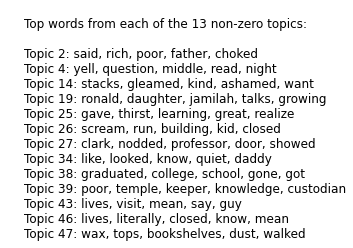

In [15]:
# topic words
fig = display_top_words(x, lda);
fig.savefig(fname='topic_words.pdf')

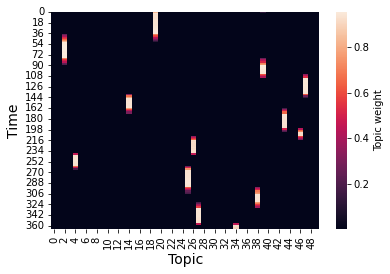

In [16]:
# topic timecourse (video)
fig = plt.gcf()
sns.heatmap(x, cbar_kws={'label': 'Topic weight'})
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Time', fontsize=14);
fig.savefig(fname='topic_timecourse.pdf')

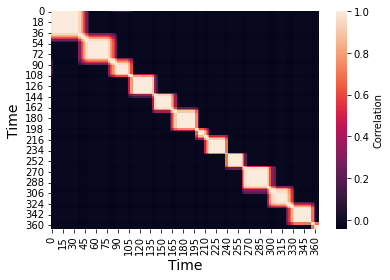

In [17]:
# temporal correlation matrix
fig = plt.gcf()
sns.heatmap(1 - squareform(pdist(x, metric='correlation')), cbar_kws={'label': 'Correlation'})
plt.xlabel('Time', fontsize=14)
plt.ylabel('Time', fontsize=14);
fig.savefig(fname='topic_corrmat.pdf')

In [18]:
# get events for video, immediate recall, and delayed recall
_, _, _, transcript_events, immediate_events, delayed_events = \
        get_video_and_recall_trajectories(data['experiment'], width=20, end=None, doc_model=lda, doc_name='LDA', window_model=lda, window_name='LDA')

  0%|          | 0/1764 [00:00<?, ?it/s]

  0%|          | 0/1764 [00:00<?, ?it/s]

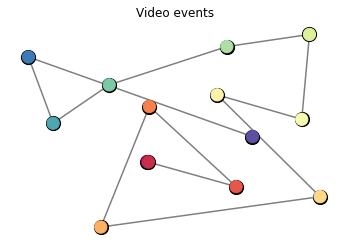

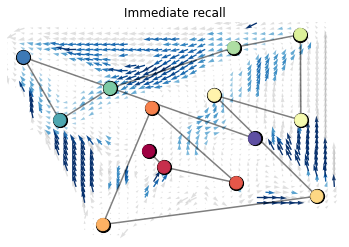

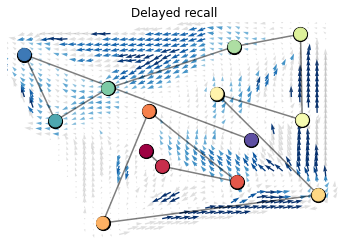

In [19]:
# plot trajectories: video, immediate recall, and delayed recall
f1, f2, f3 = plot_trajectories(transcript_events, immediate_events, delayed_events)
f1.savefig(fname='video_trajectory.pdf')
f2.savefig(fname='immediate_recall_trajectory.pdf')
f3.savefig(fname='delayed_recall_trajectory.pdf')

In [20]:
immediate_precision = pd.Series(precision(transcript_events, immediate_events))
delayed_precision = pd.Series(precision(transcript_events, delayed_events))

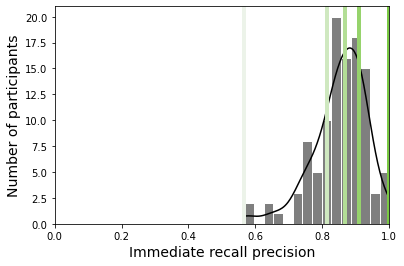

In [21]:
distplot(immediate_precision, bounds, task_cmaps['Naturalistic recall'], x='Immediate recall precision')
plt.savefig('immediate_recall_precision.pdf')

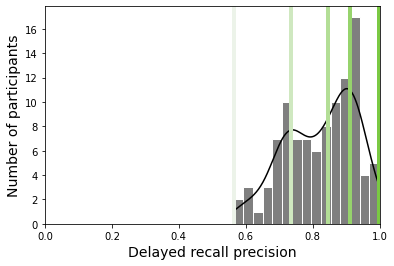

In [22]:
distplot(delayed_precision, bounds, task_cmaps['Naturalistic recall'], x='Delayed recall precision')
plt.savefig('delayed_recall_precision.pdf')

## Foreign language flashcards

Probability (proportion) of correct responses for the immediate and delayed tests

In [23]:
def vocab_barplot(data, cond, trials, bounds, cmap, valcond='all', **kwargs):
    x = data[[('vocab learning', cond, f'p(correct): {x}') for x in trials]]
    x = pd.DataFrame(data=x.values, columns=[t.capitalize() for t in trials], index=x.index)
    x['group'] = np.digitize(x[valcond.capitalize()], get_bounds(x[valcond.capitalize()], bounds=bounds))
    x = x.query(f'group < {len(bounds)}')
    
    fig = sns.barplot(data=x.melt(ignore_index=False, id_vars=['group'], value_vars=['Early', 'Late', 'All'],
                                  var_name='position'),
                       x='position', y='value', hue='group',
                      palette=cmap, **kwargs)
    
    ax = plt.gca()
    ax.get_legend().remove()
    
    plt.xlabel('Stimulus position', fontsize=14)
    plt.ylabel('Recall probability', fontsize=14)
    ax.set_ylim([0, 1.05])
    return fig, x.drop(columns=['group'])

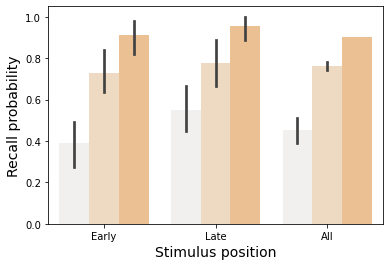

In [24]:
trials = ['early', 'late', 'all']
_, vocab_immediate = vocab_barplot(behavioral, 'immediate', trials, bounds,
                                   task_cmaps['Foreign language flashcards'])
plt.savefig('vocab_immediate_recall.pdf')

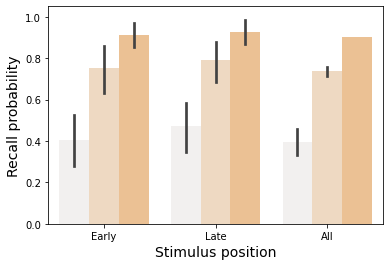

In [25]:
_, vocab_delayed = vocab_barplot(behavioral, 'delayed', trials, bounds,
                                 task_cmaps['Foreign language flashcards'])
plt.savefig('vocab_delayed_recall.pdf')

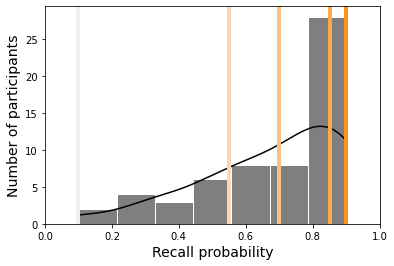

In [26]:
distplot(vocab_immediate['All'], bounds=bounds, cmap=task_cmaps['Foreign language flashcards'], x='Recall probability', bins=7)
plt.savefig('vocab_immediate_dist.pdf')

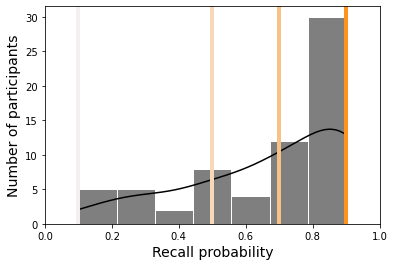

In [27]:
distplot(vocab_delayed['All'], bounds=bounds, cmap=task_cmaps['Foreign language flashcards'], x='Recall probability', bins=7)
plt.savefig('vocab_delayed_dist.pdf')

## Spatial learning

Mean error by number of shapes.  Also show distribution of intercepts and slopes of lines fit to error as a function of the number of shapes.  (For slopes and intercepts, multiply by negative 1 and normalize to the [0, 1] interval so that more positive values denote better performance, as for the other measures.)

In [28]:
spatial_errors = pd.DataFrame(index=behavioral.index,
                              columns=np.arange(2, 8),
                              data=pd.concat([spatial_estimation_error(data['experiment'], [i]) for i in range(2, 8)], axis=1).values)

spatial_reg = pd.DataFrame(index=spatial_errors.index, columns=['intercept', 'slope'])
for s in range(spatial_reg.shape[0]):
    reg = LinearRegression().fit(np.atleast_2d(np.arange(2, 8)).T,
                                 np.atleast_2d(spatial_errors.iloc[s]).T)
    spatial_reg.iloc[s]['slope'] = float(reg.coef_)
    spatial_reg.iloc[s]['intercept'] = float(reg.intercept_)

In [29]:
# flip and normalize slopes and intercepts
def flip_and_norm(x):
    x = x.copy()
    x *= -1
    x -= np.min(x)
    x /= np.max(x)
    return x
    

spatial_reg['slope'] = flip_and_norm(spatial_reg['slope'])
spatial_reg['intercept'] = flip_and_norm(spatial_reg['intercept'])

In [30]:
# group by intercept
spatial_errors['intercept group'] = np.digitize(spatial_reg['intercept'], get_bounds(spatial_reg['intercept'], bounds=bounds))
spatial_errors['slope group'] = np.digitize(spatial_reg['slope'], get_bounds(spatial_reg['slope'], bounds=bounds))

In [31]:
def spatial_barplot(errors, group_id, cmap):
    fig = sns.barplot(data=errors.melt(ignore_index=False, value_vars=list(np.arange(2, 8)),
                                       id_vars=[group_id],
                                       var_name='Number of shapes'),
                  x='Number of shapes', y='value', hue=group_id, palette=cmap)
    
    ax = plt.gca()
    ax.get_legend().remove()
    
    plt.xlabel('Number of shapes', fontsize=14)
    plt.ylabel('Estimation error', fontsize=14)
    return fig

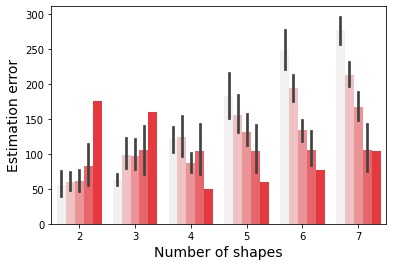

In [32]:
fig = spatial_barplot(spatial_errors, 'slope group', task_cmaps['Spatial learning'])
plt.savefig('spatial_error_slope_groups.pdf')

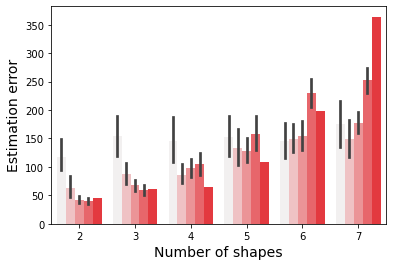

In [33]:
fig = spatial_barplot(spatial_errors, 'intercept group', task_cmaps['Spatial learning'])
plt.savefig('spatial_error_intercept_groups.pdf')

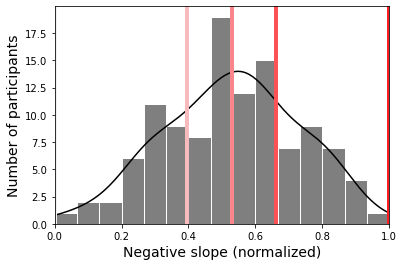

In [34]:
distplot(spatial_reg['slope'], bounds=bounds, cmap=task_cmaps['Spatial learning'], x='Negative slope (normalized)')
plt.savefig('spatial_slope_dist.pdf')

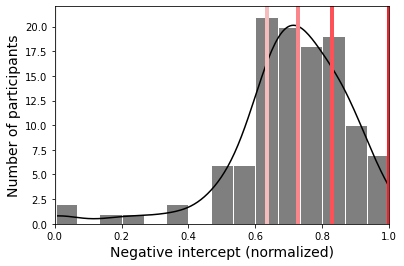

In [35]:
distplot(spatial_reg['intercept'], bounds=bounds, cmap=task_cmaps['Spatial learning'], x='Negative intercept (normalized)')
plt.savefig('spatial_intercept_dist.pdf')

## Save a summary

Save a dataframe containing summary performance metrics for each task, for each participant

In [36]:
performance = pd.DataFrame(index=behavioral.index)

# Free recall: p(recall), immediate + delayed
performance['Free recall (immediate)'] = immediate_fr.analyze('accuracy').data.groupby('Subject').mean().values
performance['Free recall (delayed)'] = delayed_split.analyze('accuracy').data.groupby('Subject').mean().values

# Naturalistic recall: mean precision, immediate + delayed
performance['Naturalistic recall (immediate)'] = immediate_precision.values
performance['Naturalistic recall (delayed)'] = delayed_precision.values

# Foreign language flashcards: p(recall), immediate + delayed
performance['Foreign language flashcards (immediate)'] = vocab_immediate['All']
performance['Foreign language flashcards (delayed)'] = vocab_delayed['All']

# Spatial learning: regression (error as a function of number of shapes)-- flipped + normalized slope and intercept
performance['Spatial learning (intercept)'] = spatial_reg['intercept']
performance['Spatial learning (slope)'] = spatial_reg['slope']

In [37]:
performance

,Free recall (immediate),Free recall (delayed),Naturalistic recall (immediate),Naturalistic recall (delayed),Foreign language flashcards (immediate),Foreign language flashcards (delayed),Spatial learning (intercept),Spatial learning (slope)
P0,0.515625,0.187500,0.901203,0.917849,NaN,NaN,0.740677,0.620953
P1,0.984375,0.906250,0.850649,0.563574,0.8,NaN,0.830731,0.496952
P2,0.671875,0.265625,0.910146,0.831101,0.7,0.7,0.962055,0.080893
P3,0.468750,0.312500,0.851312,0.885206,NaN,NaN,0.801884,0.500854
P4,0.640625,0.328125,0.746228,0.773765,0.8,0.8,0.629321,0.80549
...,...,...,...,...,...,...,...,...
P108,0.281250,0.140625,0.728443,0.715547,0.3,0.5,0.254845,0.761135
P109,0.640625,0.375000,0.649809,0.780077,0.8,0.7,0.576616,0.617924
P110,0.453125,0.015625,0.874351,0.768864,0.9,0.7,0.784739,0.468243
P111,0.328125,0.062500,NaN,0.998227,0.6,0.5,0.612979,0.81629


In [38]:
with open(os.path.join(DATA_DIR, 'behavioral_summary.pkl'), 'wb') as f:
    pickle.dump(performance, f)